In [1]:
import folium
import numpy as np
import geopandas as gpd
import pandas as pd
from branca.colormap import linear
from branca.colormap import LinearColormap

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def crear_paleta(nombre,data,variable):
    cm = plt.get_cmap(nombre)
    paleta = LinearColormap(colors = [cm(0.),cm(0.25),cm(0.5),cm(0.75),cm(1.)],
                              vmin = data[variable].min(),
                              vmax= data[variable].max())
    return paleta

def crear_layer(data,variable,etiqueta,nombre_paleta = 'viridis',barra = False):
    #colormap
    colormap = crear_paleta(nombre = nombre_paleta,data = data,variable =variable)
    layer = folium.GeoJson(
            data,
            name=etiqueta,
            style_function=lambda feature: {
                'fillColor':colormap(feature['properties'][variable]),
                'line_opacity':0.2,
                'weight':0,
                'fillOpacity': 0.6,
            }
        )
    if barra:        
        colormap.caption = etiqueta
        #colormap.add_to(m)

        return layer,colormap
    else:
        return layer
    
def crear_mapa(data,variables,etiquetas,nombres_paletas,archivo = 'mapa.html',barra=False):
    m = folium.Map(
        location=[-34.6139974,-58.4],
        tiles='cartodbpositron',
        zoom_start=12
    )
    
    for variable,etiqueta,nombre_paleta in zip(variables,etiquetas,nombres_paletas):
        if barra:
            l,co = crear_layer(data=data,variable = variable,etiqueta = etiqueta,barra = barra,nombre_paleta=nombre_paleta)
            m.add_child(l)
            m.add_child(co)    
        else:
            m.add_child(crear_layer(data=data,variable = variable,etiqueta = etiqueta,barra = barra,nombre_paleta=nombre_paleta))
        
    m.add_child(folium.LayerControl())
    m.save(archivo)
    return m 

In [3]:
def f(x):
    return str(int(x))
    
caba = gpd.read_file('carto/cabaxrdatos.shp')
caba = caba.to_crs(epsg=4326)
caba['CO_FRAC_RA'] = caba.DEPTO.map(f) + '_' + caba.FRAC.map(f) + '_' + caba.RADIO.map(f) 
caba = caba.reindex(columns=['CO_FRAC_RA','geometry'])

dt = gpd.read_file('carto/basefinal.shp')
dt = dt.dropna()
dt = dt.reindex(columns = ['CO_FRAC_RA','transitGoo','tiemposBic','driveTot','mejorMod','geometry'])
dt.mejorMod = dt.mejorMod.replace({'driveTot':'Auto','tiemposBic':'Bici','transitGoog':'Transporte público'})
dt = dt.to_crs(epsg=4326)
dt = dt.drop('geometry',axis=1)

caba = caba.merge(dt,on='CO_FRAC_RA',how='inner')

In [4]:
labels = ['Hasta el 80% del tiempo', 'Entre 80% y lo mismo', 'Igual o a lo sumo 20% mas', 'Mas de un 120% del tiempo']

caba['biciVpub'] = caba.tiemposBic / caba.transitGoo
caba['biciVauto'] = caba.tiemposBic / caba.driveTot

caba['biciVpub_cat'] = pd.cut(caba['biciVpub'],[0,0.80,1,1.2,caba['biciVpub'].max()],labels = labels,right=True)
caba['biciVauto_cat'] = pd.cut(caba['biciVauto'],[0,0.80,1,1.2,caba['biciVauto'].max()],labels = labels,right=True)

In [5]:
caba.head()

,CO_FRAC_RA,geometry,transitGoo,tiemposBic,driveTot,mejorMod,biciVpub,biciVauto,biciVpub_cat,biciVauto_cat
0,13_3_2,POLYGON ((-58.4668089295639 -34.53584213862359...,67.616667,60.0,53.033333,Auto,0.887355,1.131364,Entre 80% y lo mismo,Igual o a lo sumo 20% mas
1,13_1_4,POLYGON ((-58.46845766676697 -34.5353220290669...,53.316667,64.0,60.000000,Transporte público,1.200375,1.066667,Mas de un 120% del tiempo,Igual o a lo sumo 20% mas
2,13_1_4,POLYGON ((-58.46580936255169 -34.5374880407435...,53.316667,64.0,60.000000,Transporte público,1.200375,1.066667,Mas de un 120% del tiempo,Igual o a lo sumo 20% mas
3,13_1_3,POLYGON ((-58.46845766676697 -34.5353220290669...,52.000000,64.0,57.733333,Transporte público,1.230769,1.108545,Mas de un 120% del tiempo,Igual o a lo sumo 20% mas
4,13_1_2,POLYGON ((-58.47002341993829 -34.5369550514657...,54.016667,68.0,62.066667,Transporte público,1.258871,1.095596,Mas de un 120% del tiempo,Igual o a lo sumo 20% mas


In [21]:
pob = gpd.read_file('carto/informacion_censal_por_radio_2010.shp')
pob = pob.reindex(columns=['CO_FRAC_RA','TOTAL_POB'])
pob = pob.merge(caba.reindex(columns = ['CO_FRAC_RA','mejorMod','biciVauto_cat']),how='left')

In [22]:
pob_por_prop_auto = pob.groupby('biciVauto_cat').sum()
pob_por_prop_auto.TOTAL_POB = round((pob_por_prop_auto.TOTAL_POB /pob_por_prop_auto.TOTAL_POB.sum() * 100),1)
pob_por_prop_auto

,TOTAL_POB
biciVauto_cat,
Hasta el 80% del tiempo,48.8
Entre 80% y lo mismo,24.6
Igual o a lo sumo 20% mas,8.9
Mas de un 120% del tiempo,17.6


In [23]:
pob_por_mejor_modo = pob.groupby('mejorMod').sum()
pob_por_mejor_modo.TOTAL_POB = round((pob_por_mejor_modo.TOTAL_POB /pob_por_mejor_modo.TOTAL_POB.sum() * 100),1)

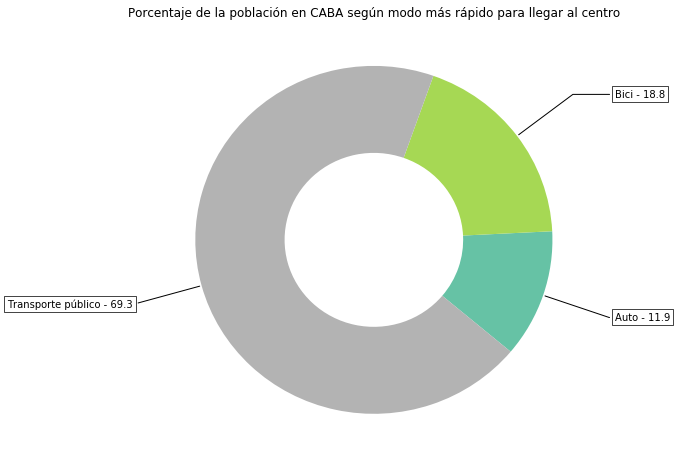

In [30]:
cm = plt.get_cmap('Set2')
colores = cm(np.linspace(0,1,3))

f,ax=plt.subplots(1,figsize=(8,8))
wedges, texts = ax.pie(pob_por_mejor_modo.TOTAL_POB, wedgeprops=dict(width=0.5), startangle=-40,colors = colores);

#wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(pob_por_mejor_modo.index[i]+' - '+str(pob_por_mejor_modo.TOTAL_POB[i]), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Porcentaje de la población en CABA según modo más rápido para llegar al centro")
f.savefig('poblacion_por_modo_mas_rapido.png');

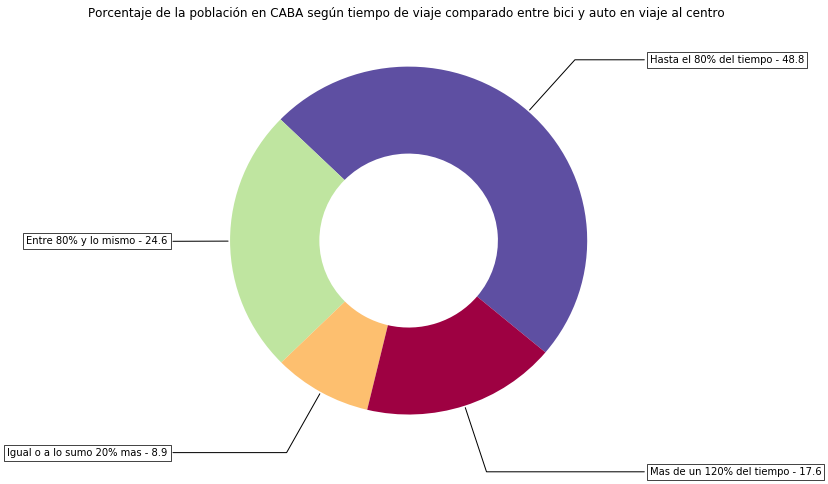

In [31]:
cm = plt.get_cmap('Spectral_r')
colores = cm(np.linspace(0,1,4))

f,ax=plt.subplots(1,figsize=(8,8))
wedges, texts = ax.pie(pob_por_prop_auto.TOTAL_POB, wedgeprops=dict(width=0.5), startangle=-40,colors = colores);


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(pob_por_prop_auto.index[i]+' - '+str(pob_por_prop_auto.TOTAL_POB[i]), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Porcentaje de la población en CABA según tiempo de viaje comparado entre bici y auto en viaje al centro ");
f.savefig('poblacion_por_comparacion.png');

In [28]:
from branca.colormap import linear

colormap = linear.Spectral_05.scale(0,
    100)

colores = [colormap(100),colormap(66),colormap(33),colormap(0)]
colores_dict =  dict(zip(labels,colores))
colores_dict


{'Hasta el 80% del tiempo': '#2b83ba',
 'Entre 80% y lo mismo': '#caeaae',
 'Igual o a lo sumo 20% mas': '#fec87f',
 'Mas de un 120% del tiempo': '#d7191c'}

In [ ]:
m = folium.Map(
        location=[-34.6139974,-58.4],
        tiles='cartodbpositron',
        zoom_start=12
    )
folium.GeoJson(
    caba,
    style_function=lambda feature: {
        'fillColor':colores_dict[feature['properties']['biciVauto_cat']],
        'line_opacity':0.2,
        'weight':0,
        'fillOpacity': 0.6,
    }
).add_to(m)

from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Comparacion Bici - Auto</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#2b83ba;opacity:0.7;'></span>Hasta el 80% del tiempo</li>
    <li><span style='background:#caeaae;opacity:0.7;'></span>Entre 80% y lo mismo</li>
    <li><span style='background:#fec87f;opacity:0.7;'></span>Igual o a lo sumo 20% mas</li>
    <li><span style='background:#d7191c;opacity:0.7;'></span>Mas de un 120% del tiempo</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

m.save('bici_vs_auto.html')

In [ ]:
m = folium.Map(
        location=[-34.6139974,-58.4],
        tiles='cartodbpositron',
        zoom_start=12
    )
folium.GeoJson(
    caba,
    style_function=lambda feature: {
        'fillColor':colores_dict[feature['properties']['biciVpub_cat']],
        'line_opacity':0.2,
        'weight':0,
        'fillOpacity': 0.6,
    }
).add_to(m)

from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Comparacion Bici - Transporte publico</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#2b83ba;opacity:0.7;'></span>Hasta el 80% del tiempo</li>
    <li><span style='background:#caeaae;opacity:0.7;'></span>Entre 80% y lo mismo</li>
    <li><span style='background:#fec87f;opacity:0.7;'></span>Igual o a lo sumo 20% mas</li>
    <li><span style='background:#d7191c;opacity:0.7;'></span>Mas de un 120% del tiempo</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

m.save('bici_vs_publico.html')

In [ ]:
f,ax = plt.subplots(1,figsize=(8,8))
caba.plot(ax=ax, column = 'mejorMod',legend=True,cmap='Set2')

In [ ]:
mapa = crear_mapa(data = caba,
                  variables = ['transitGoo','tiemposBic','driveTot'],
                  etiquetas = ['Transporte publico (min)','Bici (min)','Auto (min)'],
                  nombres_paletas = ['inferno_r','viridis','hot_r'],
                  barra=True)